# QC inspection of: "The broccoli-derived antioxidant sulforaphane changes the growth of gastrointestinal microbiota, allowing for the production of anti-inflammatory metabolites*"

\[*\]:https://doi.org/10.1016/j.jff.2023.105645

Simple proteomics experiment, 8 batches of E. coli grown in two groups of media, measured with QExactive+, label-free quantitative analysis with MQ followed. As a bonus, the publication also has a related metabolomics experiment.

The first important thing to note, is that it's always good to have a look at the data from the raw side of things first. Like so, we discovered two raw files of the experiment, EG1 and EG2, to be damaged during transmission and deposition in PRIDE archive. This was fixed by contacting the authors who reshared the files for an easy fix to the dataset. 

Everything following is done with preparation work as was with the previous datasets. LSF batched: 1. raw conversion with ThermoRawFileParser, 2. Identification with Ecoli K12 Uniprot proteome database and comet, 3. mzQC construction from mzML/mzid input, demonstrating the use of the libraries. 

In [1]:
import os
import re
import datetime as dt
from typing import Dict,List,Tuple
import numpy as np
import pandas as pd
from mzqc import MZQCFile as qc
import matplotlib.pyplot as plt

## First load the mzQC into memory
To begin, we will load all the runs' mzQC files and merge them into a complete DataFrame of metric values, one run per row

In [2]:
# Read the files to memory
mzqc_folder = "../test_data/PXD040621/"
jmzqcs = dict()
for f in [f for f in os.listdir(mzqc_folder) if "jmzqc" in f ]:
  with open(os.path.join(mzqc_folder,f), "r") as file:
    mzqcobj = qc.JsonSerialisable.FromJson(file)
    jmzqcs[os.path.splitext(os.path.splitext(f)[0])[0]]=mzqcobj
rmzqcs = dict()
for f in [f for f in os.listdir(mzqc_folder) if "rmzqc" in f ]:
  with open(os.path.join(mzqc_folder,f), "r") as file:
    mzqcobj = qc.JsonSerialisable.FromJson(file)
    rmzqcs[os.path.splitext(os.path.splitext(f)[0])[0]]=mzqcobj
pmzqcs = dict()
for f in [f for f in os.listdir(mzqc_folder) if "pymzqc" in f ]:
  with open(os.path.join(mzqc_folder,f), "r") as file:
    mzqcobj = qc.JsonSerialisable.FromJson(file)
    pmzqcs[os.path.splitext(os.path.splitext(f)[0])[0]]=mzqcobj

In [3]:
# Merge the mzQC values into a DataFrame
def load_jdf(mzqc_dict: Dict[str, qc.MzQcFile]):
  df = pd.DataFrame([{'mz_range': next(iter([cd.value for cd in rowrunmzqc.runQualities[0].qualityMetrics if cd.accession=="MS:4000069"])),
                      'rt_range': next(iter([cd.value for cd in rowrunmzqc.runQualities[0].qualityMetrics if cd.accession=="MS:4000070"])),
                      'basepeakintensities_sum': next(iter([pd.Series(cd.value).sum() for cd in rowrunmzqc.runQualities[0].qualityMetrics if cd.accession=="MS:1000505"])),
                      'ticintensities_sum': next(iter([pd.DataFrame(cd.value)["MS:1000285"].sum() for cd in rowrunmzqc.runQualities[0].qualityMetrics if cd.accession=="MS:4000104"])),
                      'run_name':rowrunname,
                      } for rowrunname, rowrunmzqc in jmzqcs.items()])
  df = df.join(pd.DataFrame(df.pop('mz_range').tolist(), index=df.index, columns=["mz_min", "mz_max"]))
  df = df.join(pd.DataFrame(df.pop('rt_range').tolist(), index=df.index, columns=["rt_min", "rt_max"]))
  return df

def load_rdf(mzqc_dict: Dict[str, qc.MzQcFile]):
  df = pd.DataFrame([{'MS1_ict_mean': next(iter([cd.value for cd in rowrunmzqc.runQualities[0].qualityMetrics if cd.accession=="MS:4000132"])),
                    'MS1_ict_std': next(iter([cd.value for cd in rowrunmzqc.runQualities[0].qualityMetrics if cd.accession=="MS:4000133"])),
                    'MS2_ict_mean': next(iter([cd.value for cd in rowrunmzqc.runQualities[0].qualityMetrics if cd.accession=="MS:4000137"])),
                    'MS2_ict_std': next(iter([cd.value for cd in rowrunmzqc.runQualities[0].qualityMetrics if cd.accession=="MS:4000138"])),
                    'run_name':rowrunname,
                    } for rowrunname, rowrunmzqc in rmzqcs.items()])
  return df

def load_pdf(mzqc_dict: Dict[str, qc.MzQcFile]):
  df = pd.DataFrame([{'num_MS2': next(iter([cd.value for cd in rowrunmzqc.runQualities[0].qualityMetrics if cd.accession=="MS:4000060"])),
                      'num_id_MS2': next(iter([cd.value for cd in rowrunmzqc.runQualities[0].qualityMetrics if cd.accession=="MS:1003251"])),
                      'id_pep': next(iter([cd.value for cd in rowrunmzqc.runQualities[0].qualityMetrics if cd.accession=="MS:1003250"])),
                      'id_prot': next(iter([cd.value for cd in rowrunmzqc.runQualities[0].qualityMetrics if cd.accession=="MS:1002404"])),
                      "num_mc": pd.DataFrame(next(iter([cd.value for cd in rowrunmzqc.runQualities[0].qualityMetrics if cd.name=="enzyme digestion parameters"])))["MS:1000927"].mean(),
                      'id_rt_range': next(iter([cd.value for cd in rowrunmzqc.runQualities[0].qualityMetrics if cd.name=="retention time identification range"])),
                      'id_dppm_mean': next(iter([cd.value for cd in rowrunmzqc.runQualities[0].qualityMetrics if cd.name=="absolute dppm mean"])),
                      'id_dppm_std': next(iter([cd.value for cd in rowrunmzqc.runQualities[0].qualityMetrics if cd.name=="absolute dppm sigma"])),
                      'run_name':rowrunname,
                      } for rowrunname, rowrunmzqc in pmzqcs.items()])
  df = df.join(pd.DataFrame(df.pop('id_rt_range').tolist(), index=df.index, columns=["id_rt_min", "id_rt_max"])*60)
  return df


In [4]:
mzqc_df = pd.concat([load_jdf(jmzqcs).set_index('run_name'),
           load_rdf(rmzqcs).set_index('run_name'),
           load_pdf(pmzqcs).set_index('run_name')], axis=1, join="inner").astype('float')
mzqc_df.head(3)

,basepeakintensities_sum,ticintensities_sum,mz_min,mz_max,rt_min,rt_max,MS1_ict_mean,MS1_ict_std,MS2_ict_mean,MS2_ict_std,num_MS2,num_id_MS2,id_pep,id_prot,num_mc,id_dppm_mean,id_dppm_std,id_rt_min,id_rt_max
run_name,,,,,,,,,,,,,,,,,,,
20220830_JL-4884_Forster_Ecoli_Suf_rep4_EG-8,2.459922e+12,2.359548e+13,374.999634,1799.656982,360.17840,7500.3164,15.3199,20.0145,53.2581,15.6195,51299.0,8825.0,3828.0,1384.0,0.093258,8.800701,8.479578,3317.21856,7345.8918
20220830_JL-4884_Forster_Ecoli_DMSO_rep2_EG-2,2.270682e+12,2.131104e+13,374.995392,1799.746826,360.17603,7500.3770,12.8445,18.3948,53.8966,14.9487,51693.0,8157.0,3250.0,1299.0,0.081035,8.389892,8.464230,3311.62158,7344.7170
20220830_JL-4884_Forster_Ecoli_Suf_rep2_EG-6,2.446767e+12,2.344012e+13,374.999359,1799.925903,360.17517,7500.1157,13.3447,18.7560,53.4835,15.4368,51761.0,8919.0,3425.0,1334.0,0.082633,8.888364,8.468234,3417.55746,7384.7208


## Add run meta-data 
The runs were acquired in non-sequential order as shown below. 
So we will add a column for the order of sequence [1,8] so we can sort the runs by date if needbe.

In [5]:
mzqc_df.index = mzqc_df.index.str.removeprefix("20220830_JL-4884_Forster_")
mzqc_df.sort_index(inplace=True)
mzqc_df = mzqc_df.assign(date_order=[1,2,4,7,6,3,5,8]).assign(group=[*["DMSO"]*4,*["Suf"]*4])
mzqc_df.describe()

,basepeakintensities_sum,ticintensities_sum,mz_min,mz_max,rt_min,rt_max,MS1_ict_mean,MS1_ict_std,MS2_ict_mean,MS2_ict_std,num_MS2,num_id_MS2,id_pep,id_prot,num_mc,id_dppm_mean,id_dppm_std,id_rt_min,id_rt_max,date_order
count,8.000000e+00,8.000000e+00,8.000000,8.000000,8.000000,8.000000,8.000000,8.000000,8.000000,8.000000,8.000000,8.000000,8.000000,8.00000,8.000000,8.000000,8.000000,8.000000,8.00000,8.00000
mean,2.370818e+12,2.256391e+13,374.998093,1799.856766,360.178986,7500.143288,13.427750,19.242150,53.626788,15.255100,51697.000000,8667.625000,3284.000000,1299.75000,0.079674,8.485442,8.484319,3151.103723,7391.17680,4.50000
std,1.870375e+11,1.905778e+12,0.002023,0.111287,0.002760,0.248206,1.267512,0.694098,0.563205,0.628658,668.186886,419.585488,390.328067,74.41534,0.019565,0.546323,0.174728,573.181586,50.52935,2.44949
min,2.092294e+12,1.972246e+13,374.995392,1799.656982,360.175170,7499.571000,11.731000,18.394800,52.925800,14.326500,50730.000000,8154.000000,2512.000000,1139.00000,0.034533,7.245128,8.159196,1763.923140,7344.71700,1.00000
25%,2.233962e+12,2.103815e+13,374.996117,1799.779419,360.177035,7500.129425,12.702425,18.730775,53.201675,14.837625,51424.250000,8235.000000,3139.500000,1291.50000,0.079986,8.360365,8.440878,3252.740340,7354.83420,2.75000
50%,2.441354e+12,2.324523e+13,374.998962,1799.913086,360.178740,7500.184750,13.124150,18.995200,53.578200,15.333900,51592.500000,8802.000000,3318.000000,1305.00000,0.083688,8.746547,8.473906,3314.420070,7379.26320,4.50000
75%,2.485282e+12,2.380952e+13,374.999428,1799.930206,360.181480,7500.276125,14.242425,20.007675,53.983875,15.694450,51848.500000,8940.750000,3468.500000,1340.75000,0.087132,8.796105,8.585865,3418.161390,7403.80245,6.25000
max,2.575772e+12,2.472076e+13,375.000580,1799.964844,360.182400,7500.377000,15.319900,20.121000,54.499300,16.054600,53024.000000,9240.000000,3828.000000,1384.00000,0.099262,8.888364,8.752655,3549.900660,7476.69600,8.00000


(-0.5, 1.5)

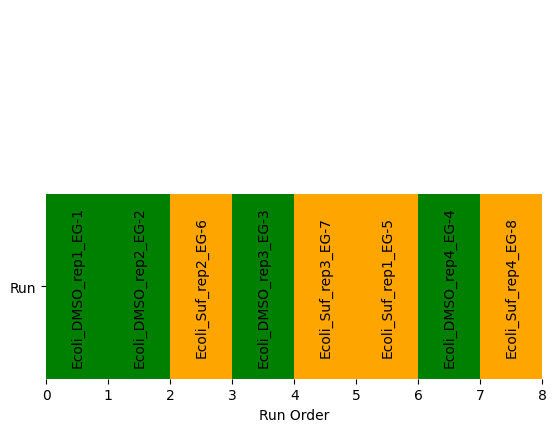

In [6]:
ax = pd.DataFrame({v:1 for v in mzqc_df.date_order.values}, index=['Run'])\
    .plot.barh(stacked=True, xlabel='Run Order', legend=False, width=1,
          color=mzqc_df.sort_values(by=['date_order']).group.replace({'DMSO':'green','Suf':'orange'}).values)

for c,n in zip(ax.containers,mzqc_df.sort_values(by=['date_order']).index.values):
    labels = [n]
    ax.bar_label(c, labels=labels, label_type='center',rotation=90)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.margins(x=0,y=0,tight=True)
ax.set_ylim(-0.5,1.5)

## Check if the technical QC metric parameters reflect the experiment grouping
We do this with a quick PCA on the metric values

In [7]:
# %pip install scikit-learn
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

features = list(set(mzqc_df.columns.values)-{'group','date_order'})
x = mzqc_df.loc[:, features].values
x = StandardScaler().fit_transform(x) # normalizing the features

x = StandardScaler().fit_transform(x)
pca = PCA(n_components=2)
pca_values = pca.fit_transform(x)

pca_df = pd.DataFrame(data = pca_values, index=mzqc_df.index,
                      columns = ['principal component 1', 'principal component 2'])

pca_df

,principal component 1,principal component 2
run_name,,
Ecoli_DMSO_rep1_EG-1,6.034717,2.227721
Ecoli_DMSO_rep2_EG-2,-0.380119,0.699391
Ecoli_DMSO_rep3_EG-3,-3.676815,3.982528
Ecoli_DMSO_rep4_EG-4,-3.541214,-0.412875
Ecoli_Suf_rep1_EG-5,2.842297,-0.884413
Ecoli_Suf_rep2_EG-6,0.429402,-1.043641
Ecoli_Suf_rep3_EG-7,-1.230990,-1.040833
Ecoli_Suf_rep4_EG-8,-0.477278,-3.527879


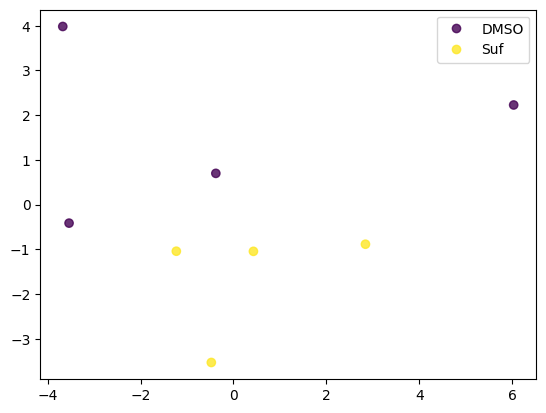

In [8]:
labels, index = np.unique(mzqc_df.group, return_inverse=True)
fig, ax = plt.subplots()
sc = ax.scatter(pca_df['principal component 1'], pca_df['principal component 2'], marker = 'o', c = index, alpha = 0.8)
ax.legend(sc.legend_elements()[0], labels)
plt.show()


This seems like a separation good enough for grouped comparison based on the metrics.
Which is not absolutely advantageous, there might be a great deal of influence from the analytical parameters to the quantiative values computed.  
However, the DMSO group seems a bit less coherent and one datum might be an outlier.
Therefore we will have a closer look at the QC metric values of each run to maybe find out if one run is truly an outlier. 

## Heatmap of the raw metric values
We will first compare the runs' metric values across the observed value range with a clustered heatmap. 
Therefore, we will scale the metric values to percentile rank values during the mapping (i.e. scale each column to [0,1]).

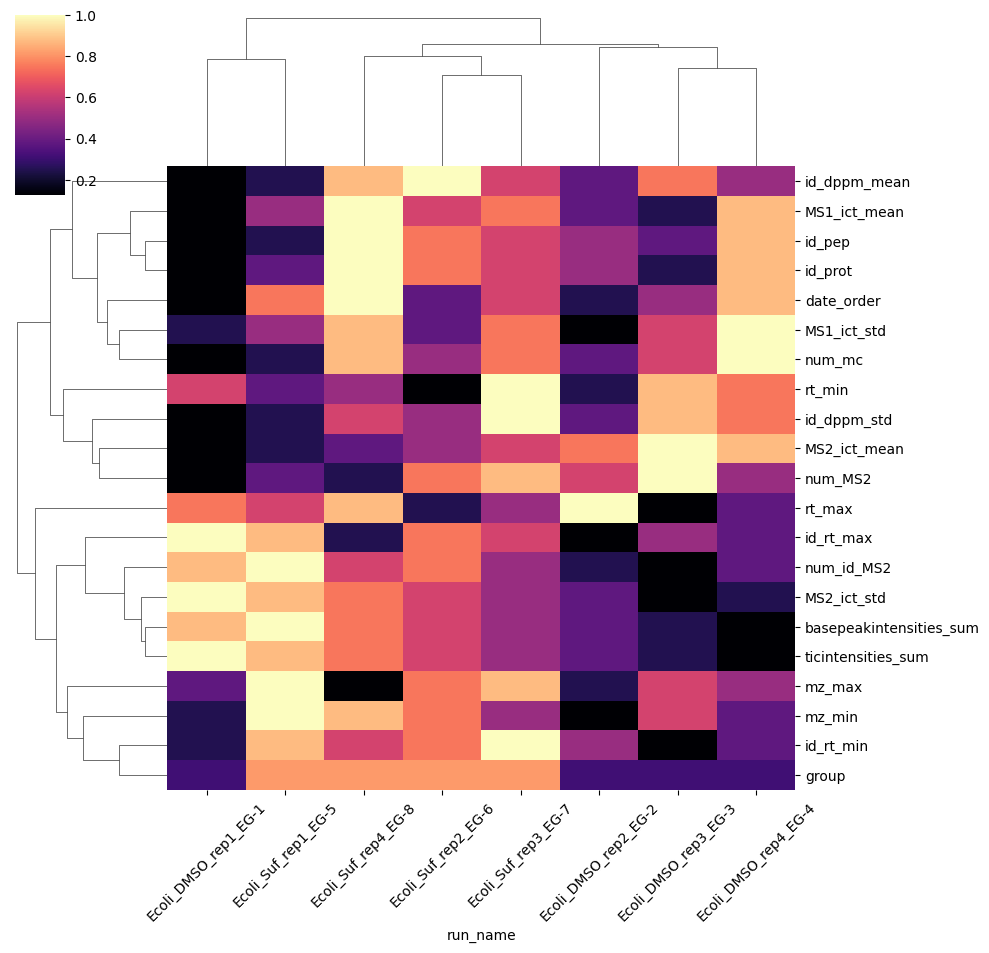

In [9]:
# %pip install seaborn 
import seaborn as sns

sns.clustermap(mzqc_df.rank(pct=True).T, cmap="magma").tick_params(axis='x', rotation=45)

We see that both DMSO and Suf groups cluster in the lower half of the heatmap, though one DMSO run (EG1) seem to be closer to one of the Suf runs (EG5). The upper half of the heatmap is clustered less clear, except  for one DMSO run (EG1). One reason might be that the metric values are considered face-value without further context in this map. We will further refine the metric scaling and consider (some) in the context of the experiment's acquisition settings and other prior knowledge, like the approximated size of the identification space. 

In [10]:
from pyteomics import parser, fasta
source = "../test_data/PXD040621/uniprot-ecoli_k12-10-2023.fasta"
db = {x for x in fasta.read(source)}
# next(iter(db)).sequence
prots = len(db)
print("prots",prots)
peps = 0
for seq in db:
 	peps += len(parser.cleave(seq.sequence, parser.expasy_rules['trypsin'], 0))
print("peps",peps)

prots 4589


peps 127966


In [11]:
SEARCHSPACE_PROTS = 4589
SEARCHSPACE_PEPS = 127966

With this new knowledge, we look first at the number of identified proteins in each run, expect 50% of the search space to be covered 
(which would correspond to a ratio of 1 in the plots below). 
We first visualise by experimental group (left), then by order of acquisition (right).
Immediately recognizable is the first run (EG1) with the lowest number of proteins covered. 
This is another indicator EG1 can rather be treated as an outlier. 
In addition, an upward trend might start to show, but overall a quarter of identified .
This points toward a great optimisation potential for the identification input parameters.

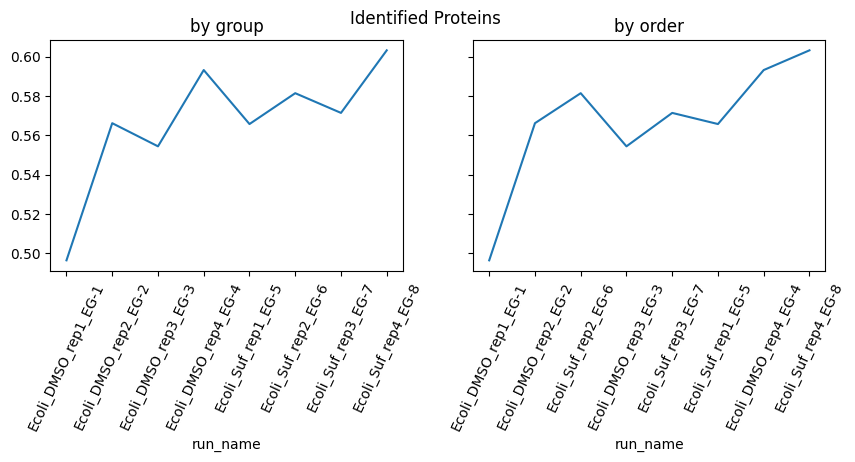

In [12]:
fig, (ax1, ax2) = plt.subplots(1, 2, sharex=False, sharey=True, figsize=(10,3))
fig.suptitle('Identified Proteins')

(mzqc_df.id_prot/(SEARCHSPACE_PROTS/2)).plot.line(ax=ax1, title = "by group").tick_params(axis='x', rotation=65)
(mzqc_df.sort_values(by=['date_order']).id_prot/(SEARCHSPACE_PROTS/2)).plot.line(ax=ax2, title="by order").tick_params(axis='x', rotation=65)

Similarly, we look at the spectra identification ratio. 
Here expecting a quarter of the spectra recorded to be identified.
We notice that it is more like a 5th of the spectra identified. 
An influence of the run order towards the identification ratio seems less likely than in the previous plot with the number of identified proteins.
In fact, the group separation, is relatively well pronounced for the spectra identification ratio.

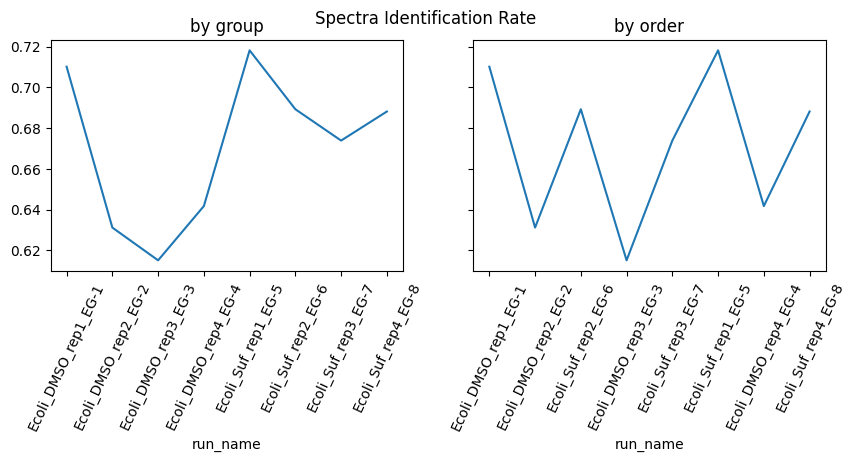

In [13]:
# ax = mzqc_df[["num_id_MS2", "num_MS2"]].plot.line().tick_params(axis='x', rotation=35)
fig, (ax1, ax2) = plt.subplots(1, 2, sharex=False, sharey=True, figsize=(10,3))
fig.suptitle('Spectra Identification Rate')

(mzqc_df['num_id_MS2']/(mzqc_df['num_MS2']/4)).plot.line(ax=ax1, title = "by group").tick_params(axis='x', rotation=65)
(mzqc_df.sort_values(by=['date_order'])['num_id_MS2']/(mzqc_df.sort_values(by=['date_order'])['num_MS2']/4)).plot.line(ax=ax2, title="by order").tick_params(axis='x', rotation=65)

We also notice, that the ratio for the first run (EG1) is among the higher values. 
Low identification numbers but a strong identification ratio leads us to assume the outlier effects seen from EG1 originate for a different reason.
Low number of MS2 with a good ratio identifiable can be due to issues with the sample type itself, 
or the issues with the isolation and collection of sufficient amounts of precursor ions for successful framgentation and subsequent identification.

One reason for the latter may be the insufficient utilisation of ion collection time or great levels of noise. 
Therefore, we inspect the mean ion collection times for MS1 first.
We see that the survey scans are fairly close in their mean ion collection time, with a loose clustering at the group level, without hints of influence by the acquisition order. 

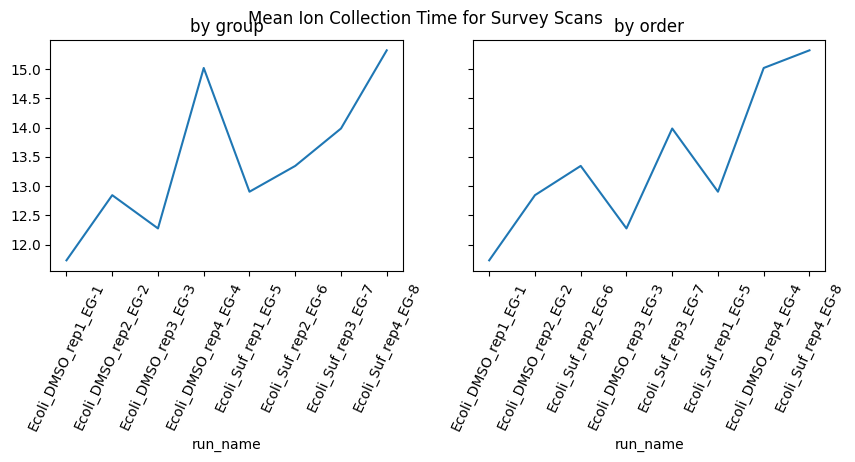

In [14]:
fig, (ax1, ax2) = plt.subplots(1, 2, sharex=False, sharey=True, figsize=(10,3))
fig.suptitle('Mean Ion Collection Time for Survey Scans')

mzqc_df['MS1_ict_mean'].plot.line(ax=ax1, title = "by group").tick_params(axis='x', rotation=65)
mzqc_df.sort_values(by=['date_order'])['MS1_ict_mean'].plot.line(ax=ax2, title = "by order").tick_params(axis='x', rotation=65)

Inspecting the MS2 mean ion collection time, we see a similar difference between the means for each group and also the survey scans.
Also, there are no hints of acquisition-order influence.
However, the 'first' runs of each group (EG1/EG5) have a markedly lower collection time than the rest of the group. 
This is less pronounced for the Suf group (EG5) and likely inconsequential since it is not connected to any other shortfalls in EG5.
For EG1 this strengthens the case for treating it as an outlier.
> The lower amount of time spent collecting both MS1 and MS2 might speak to a problem with non-protein contaminants?  
> How exactly were the machine presets? 

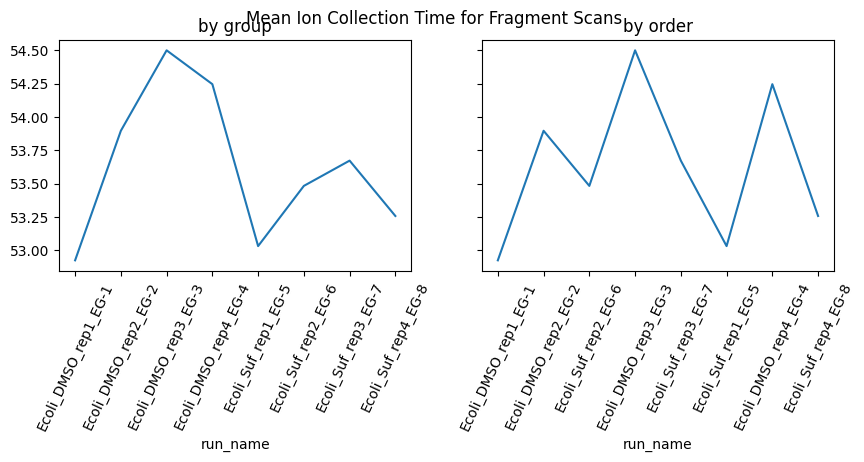

In [15]:
fig, (ax1, ax2) = plt.subplots(1, 2, sharex=False, sharey=True, figsize=(10,3))
fig.suptitle('Mean Ion Collection Time for Fragment Scans')

mzqc_df['MS2_ict_mean'].plot.line(ax=ax1, title = "by group").tick_params(axis='x', rotation=65)
mzqc_df.sort_values(by=['date_order'])['MS2_ict_mean'].plot.line(ax=ax2, title = "by order").tick_params(axis='x', rotation=65)

We can look for further evidence of a contamination issue by looking at how the signal(s) were utilised. 
Available are the basepeak intensities together with the summed total ion count intensities.
We first look at how the two values compare (left) and then can be observed from building the ratio of basepeak intensities sums and toatl ion count intensities.
Here again the first run (EG1) appears to go against the trend, acquisition order interference has been discarded (not shown).   
We can hazard a guess that though a lot of signal was registered at the base peaks, the amount of ion signal that can be processed was less in EG1 when compared to the other runs, pointing towards an issue with the sample measured or the ionisation working improperly. 
> Since there are fewer MS2 in EG1 than in all other runs, we think it is no ionisation issue though that is one of the common issues with failing runs, but rather some other trivial issue like accidental dilution or the sample sitting for too long in eppis, pepetides precipitating against the container walls. Or some such.

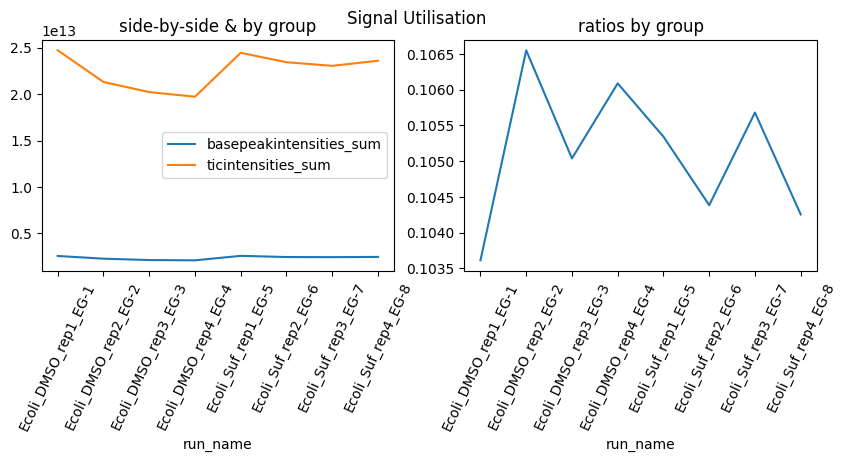

In [16]:
fig, (ax1, ax2) = plt.subplots(1, 2, sharex=False, sharey=False, figsize=(10,3))
fig.suptitle('Signal Utilisation')

(mzqc_df[['basepeakintensities_sum','ticintensities_sum']]).plot.line(ax=ax1, title = "side-by-side & by group").tick_params(axis='x', rotation=65)
# (mzqc_df['ticintensities_sum']/mzqc_df['basepeakintensities_sum']/1e-1).plot.line(ax=ax2, title = "ratios by group").tick_params(axis='x', rotation=65)
(mzqc_df['basepeakintensities_sum']/mzqc_df['ticintensities_sum']).plot.line(ax=ax2, title = "ratios by group").tick_params(axis='x', rotation=65)

Conclusion part 1: we would probably re-run EG1, at least treating it as an outlier (which their quantification rule set for proteins present in at least 3 measurements served for)

We can look at the quality of the experiment from a different perspective as we did briefly before by checking against expected results (as informed by previous runs, experience, limiting input factors, etc.) 
We therefore shape the QC metric values into a set of ratios to form a value between 0 and 100 from which we can easily gauge a run standing on its own and just as easy apply acceptance limits, which for this example __could be better informed__. 
 * The acquisition time, scaled by the gradient length setting (i.e. 7500 sec is 100%)
 * The injection times with a fixed lower limit as 0% - 50ns as per instrument settings
 * The mean of missed cleavages, with a fixed lower limit of any value > 1 and upper limit of 0 missed cleavages representing 100% (mc setting is 3 but we 'arbitrarily' set the acceptable limit of mean missed cleavages in a run to < 1)
 * For the spectra identification ratio, we set our expectations for a good run (i.e. 100%) to be at a quarter of spectra identified (1:4 ratio)
 * The longest stretch of acquisition time during which identifications were made scaled against the complete acquisition time
 * The mean identification mass accuracy (in dppm), with a fixed lower limit of any > 20 abs(deltaPPM) as 0%.
 * protein coverage, targeting to cover 1000 proteins (100%) w/ these settings seems reasonable?
 * peptide oversampling, the percentage of peptides sampled (successfully) more than once


Text(0.5, 1.0, 'by order')

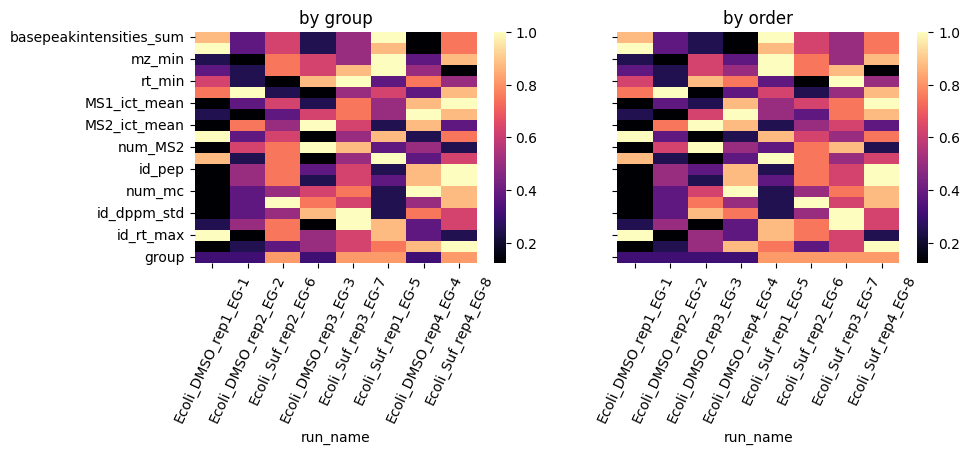

In [17]:
# I think we should scrap that
fig, (ax1, ax2) = plt.subplots(1, 2, sharex=False, sharey=True, figsize=(10,3))
sns.heatmap(mzqc_df.sort_values(by="run_name").rank(pct=True).T, cmap="magma", ax=ax2).tick_params(axis='x', rotation=65)
sns.heatmap(mzqc_df.sort_values(by=['date_order']).rank(pct=True).T, cmap="magma", ax=ax1).tick_params(axis='x', rotation=65)
ax1.set_title("by group")
ax2.set_title("by order")

In [18]:
# v acquisition times: run duration, 100% is gradient length setting (7500 sec)
# v injection times: fixed limit as 0% - 50ns as per instrument settings
# v mean of missed cleavages, 0 is 100% and >=1 is 0% (mc setting is 3 but we 'arbitrarily' set the acceptable limit of mean missed cleavages in a run to < 1)
# v spectra identification ratio, we set our expectations for a good run (i.e. 100%) to be at a quarter of spectra identified (1:4 ratio)
# v ratio of longest stretch of acquisition time with identifications and the complete acquisition time
# v mean of the identifications' dppm, 0 is 100% and 0% is anything > 20 abs(deltaPPM).
# v protein coverage, targeting to cover 1000 proteins (100%) w/ these settings seems reasonable?
# v peptide oversampling, the percentage of peptides sampled (successfully) more than once
# v what exactly do we do about the basepeaks
df_scaled = mzqc_df.assign(
						acquisition_time=lambda x: (x['rt_max']-x['rt_min'])/7500,
						injection_time_ms1=lambda x: x['MS1_ict_mean']/25.,
						injection_time_ms2=lambda x: x['MS2_ict_mean']/50.,
                		missed_cleavages=lambda x: 1 - x['num_mc']/1.,
                		spec_id_ratio=lambda x: x['num_id_MS2']/(x['num_MS2']/4),
						rt_id_ratio=lambda x: (x['id_rt_max']-x['id_rt_min'])/(x['rt_max']-x['rt_min']),
            		    dppm=lambda x: 1 - x['id_dppm_mean']/20.,
						proteins=lambda x: x['id_prot']/(SEARCHSPACE_PROTS/2),
						peptide_oversampling=lambda x: 1-(x['id_pep']/x['num_id_MS2']),
        		        signal_use_ratio=lambda x: (1e-1 - (x['basepeakintensities_sum']/x['ticintensities_sum']))*-1e2,
).drop(columns=mzqc_df.columns).clip(0,1) * 100

# 
# df_scaled = df3
# df3['hierarchy']=ListOfIndices
# df3 = df3.sort_values(by=['hierarchy']).drop(columns=['hierarchy'])

In [19]:
df_scaled.sort_index(axis=1,level=['acquisition_time', 'injection_time_ms1', 'injection_time_ms2',
              'signal_use_ratio','missed_cleavages', 'proteins', 'rt_id_ratio', 'spec_id_ratio', 
              'dppm', 'peptide_oversampling'])

,acquisition_time,dppm,injection_time_ms1,injection_time_ms2,missed_cleavages,peptide_oversampling,proteins,rt_id_ratio,signal_use_ratio,spec_id_ratio
run_name,,,,,,,,,,
Ecoli_DMSO_rep1_EG-1,95.201115,63.774361,46.9240,100.0,96.546747,72.107484,49.640445,60.772732,36.117184,71.011236
Ecoli_DMSO_rep2_EG-2,95.202680,58.050542,51.3780,100.0,91.896531,60.156920,56.613641,56.484340,65.495451,63.118798
Ecoli_DMSO_rep3_EG-3,95.191851,56.027137,49.1048,100.0,91.525632,61.454501,55.436914,78.599368,50.375057,61.511768
Ecoli_DMSO_rep4_EG-4,95.199370,56.443236,60.0732,100.0,90.073841,56.433846,59.315755,56.956286,60.868724,64.173075
Ecoli_Suf_rep1_EG-5,95.200328,58.641075,51.6144,100.0,92.316017,66.136364,56.570059,56.597483,53.415105,71.814402
Ecoli_Suf_rep2_EG-6,95.199207,55.558179,53.3788,100.0,91.736742,61.598834,58.139028,55.562975,43.837413,68.924480
Ecoli_Suf_rep3_EG-7,95.199801,56.091292,55.9352,100.0,91.491058,61.430687,57.136631,53.686220,56.791881,67.386924
Ecoli_Suf_rep4_EG-8,95.201840,55.996497,61.2796,100.0,90.674221,56.623229,60.318152,56.422904,42.539635,68.812258


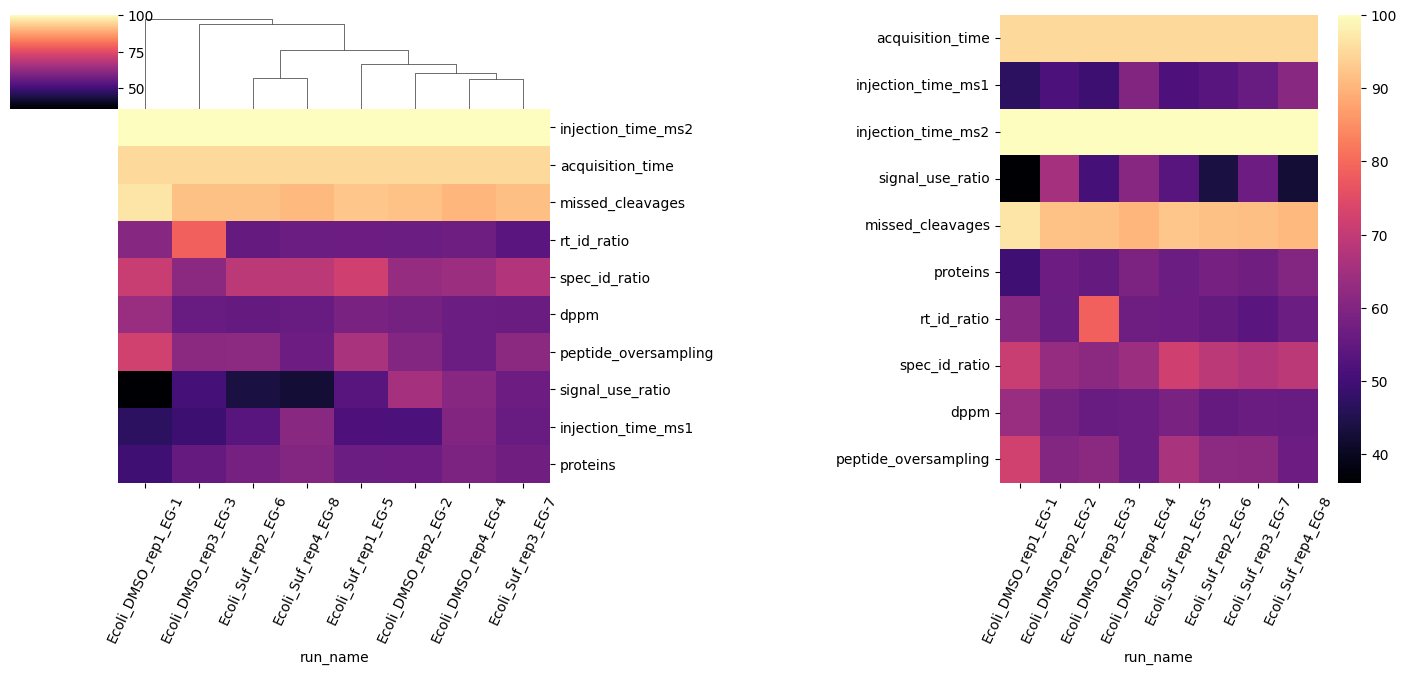

In [20]:
from matplotlib import gridspec
cm_ = sns.clustermap(df_scaled.T, xticklabels=True, yticklabels=True, cmap="magma")
cm_.fig.set_figwidth(18)
cm_.fig.set_figheight(6)

# https://stackoverflow.com/a/42418968/3319796
# Let cg be the clustermap instance returned by Seaborn.
# After drawing the clustermap, type the following to remove the row dendrogram.
cm_.ax_row_dendrogram.set_visible(False)
# cm_.ax_col_dendrogram.set_visible(False)

# If you want to preserve the legend, type:
# cm_.ax_row_dendrogram.set_xlim([0,0])
cm_.tick_params(axis='x', rotation=65)
cm_.gs.update(left=0.05, right=0.35)

gs2 = gridspec.GridSpec(1,1, left=0.6)
# create axes within this new gridspec
ax2 = cm_.fig.add_subplot(gs2[0])
# plot in the new axes
sns.heatmap(df_scaled.reindex(columns=['acquisition_time', 'injection_time_ms1', 'injection_time_ms2',
              'signal_use_ratio','missed_cleavages', 'proteins', 'rt_id_ratio', 'spec_id_ratio', 
              'dppm', 'peptide_oversampling']).T, cmap="magma", ax=ax2).tick_params(axis='x', rotation=65)


In [21]:
tics_df = pd.concat([pd.DataFrame(next(iter([cd.value for cd in rowrunmzqc.runQualities[0].qualityMetrics if cd.accession=="MS:4000104"]))).assign(run=runname) for runname,rowrunmzqc in jmzqcs.items()])
tics_df.run = tics_df.run.str.removeprefix("20220830_JL-4884_Forster_")
tics_df
# RT =MS:1000894
# TIC=MS:1000285

,MS:1000285,MS:1000894,MS:1000767,MS:1003059,run
0,10656895.0,360.17840,scan=controllerType=0 controllerNumber=1 scan=1,1081,Ecoli_Suf_rep4_EG-8
1,10739658.0,360.52927,scan=controllerType=0 controllerNumber=1 scan=2,1043,Ecoli_Suf_rep4_EG-8
2,11090322.0,360.88602,scan=controllerType=0 controllerNumber=1 scan=3,1147,Ecoli_Suf_rep4_EG-8
3,10446572.0,361.23755,scan=controllerType=0 controllerNumber=1 scan=4,1022,Ecoli_Suf_rep4_EG-8
4,10620622.0,361.58853,scan=controllerType=0 controllerNumber=1 scan=5,1090,Ecoli_Suf_rep4_EG-8
...,...,...,...,...,...
8918,13506564.0,7498.85840,scan=controllerType=0 controllerNumber=1 scan=...,782,Ecoli_DMSO_rep1_EG-1
8919,13359565.0,7499.20900,scan=controllerType=0 controllerNumber=1 scan=...,794,Ecoli_DMSO_rep1_EG-1
8920,13188523.0,7499.56100,scan=controllerType=0 controllerNumber=1 scan=...,778,Ecoli_DMSO_rep1_EG-1
8921,13525937.0,7499.91160,scan=controllerType=0 controllerNumber=1 scan=...,829,Ecoli_DMSO_rep1_EG-1


Text(0, 0.5, 'Intensity[counts]')

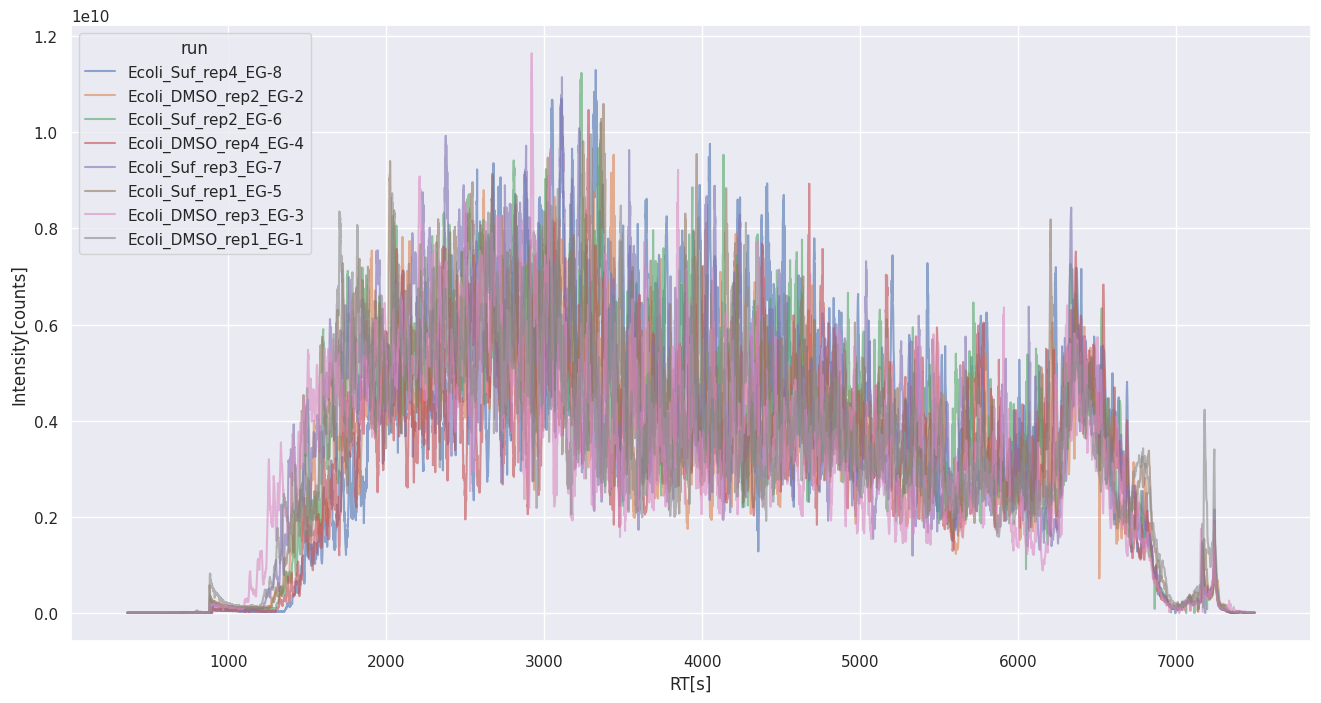

In [22]:
# tics_df[['MS:1000285', 'MS:1000894','run']].groupby('run').plot.line(x='MS:1000894', y='MS:1000285', xlabel="RT[s]", ylabel="Intensity[counts]", subplots=False)
sns.set(rc={'figure.figsize':(16,8)})
ax = sns.lineplot(data=tics_df, x='MS:1000894', y='MS:1000285', hue="run", alpha=0.6)
ax.set_xlabel("RT[s]")
ax.set_ylabel("Intensity[counts]")

In [55]:
bp_dfs = [pd.DataFrame(next(iter([{"MS:1000505": cd.value for cd in rowrunmzqc.runQualities[0].qualityMetrics if cd.accession=="MS:1000505"}]))).assign(run=runname) for runname,rowrunmzqc in jmzqcs.items()]
bp_dfs = [d.assign(extrapolated_RT=np.linspace(1,7500,len(d))) for d in bp_dfs]
bp_df = pd.concat(bp_dfs)
bp_df.run = bp_df.run.str.removeprefix("20220830_JL-4884_Forster_")
bp_df

,MS:1000505,run,extrapolated_RT
0,1192828.5,Ecoli_Suf_rep4_EG-8,1.000000
1,1227599.5,Ecoli_Suf_rep4_EG-8,1.894548
2,1190531.5,Ecoli_Suf_rep4_EG-8,2.789097
3,1229815.6,Ecoli_Suf_rep4_EG-8,3.683645
4,1132836.5,Ecoli_Suf_rep4_EG-8,4.578194
...,...,...,...
8918,3515104.0,Ecoli_DMSO_rep1_EG-1,7496.637974
8919,3507549.5,Ecoli_DMSO_rep1_EG-1,7497.478480
8920,3506997.0,Ecoli_DMSO_rep1_EG-1,7498.318987
8921,3474854.2,Ecoli_DMSO_rep1_EG-1,7499.159493


Text(0, 0.5, 'Intensity[counts]')

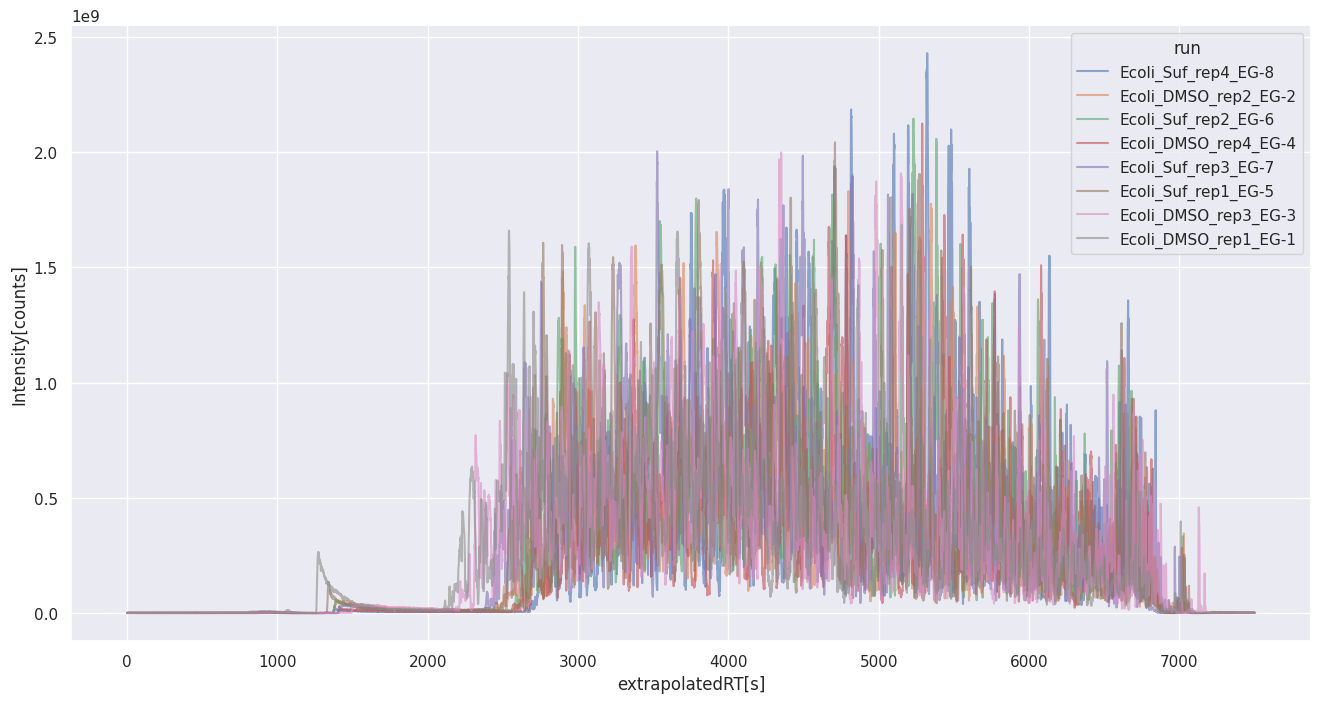

In [57]:
sns.set(rc={'figure.figsize':(16,8)})
ax = sns.lineplot(data=bp_df, y="MS:1000505", x="extrapolated_RT", hue="run", alpha=0.6)
ax.set_xlabel("extrapolatedRT[s]")
ax.set_ylabel("Intensity[counts]")